# <font  color = "#0093AF">$T_1$ and Nuclear Overhauser Effect</font>

We previously simulated $T_1$ and NOE in [solution state](../Chapter2/Ch2_T1_NOE.ipynb). In solution NMR, our motion should result in full averaging of the anisotropic interactions. In contrast, in solid-state NMR, no tumbling occurs, so anisotropic interactions remain and influence the spectrum. This also means that different orientations undergo relaxation at potentially different rates. We will characterize this behavior here, and how it depends on the presence or absence of magic angle spinning.

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../../')

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## $T_1$ anisotropy under static conditions

### Build the system

In [8]:
ex0=sl.ExpSys(v0H=600,Nucs=['13C','1H'],vr=0,LF=True,pwdavg=sl.PowderAvg(5))
ex0.set_inter('CSA',i=0,delta=200)
ex
ex1=ex0.copy()
ex1.set_inter('CSA',i=0,delta=200,euler=[0,45*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(1e-10)

seq=L.Sequence(Dt=1e-2)

rho=sl.Rho('Thermal','13Cz')

rho.DetProp(seq,n=1000)

Density Matrix/Detection Operator
rho0: Thermal
detect[0]: 13Cz
Current time is 10000000.000 microseconds
1000 time points have been recorded


<AxesSubplot:xlabel='t / ms', ylabel='<$^{13}C_z$>'>

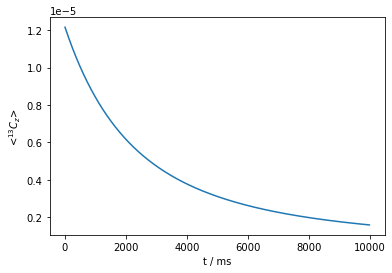

In [4]:
rho.plot()

In [5]:
ex0=sl.ExpSys(v0H=600,Nucs=['13C','1H'],vr=0,LF=True,pwdavg=sl.PowderAvg()[10])
ex0.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(.109,'1H','13C'))
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(.109,'1H','13C'),euler=[0,45*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(1e-9)

L.add_relax('DynamicThermal')

seq=L.Sequence(Dt=1e-4)
U=seq.U()**100

rho=sl.Rho('Thermal',['1Hz','13Cz'])
# L.Udelta('1H',np.pi)*rho

rho.DetProp(U,n=50000)

Density Matrix/Detection Operator
rho0: Thermal
detect[0]: 1Hz
detect[1]: 13Cz
Current time is 500000000.000 microseconds
50000 time points have been recorded


<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

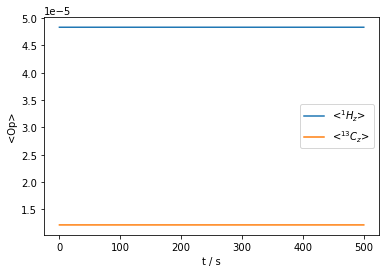

In [6]:
rho.plot(axis='s')

In [12]:
rho._detect[0]@((np.linalg.pinv(L[0].L(0))@L[0].L(0))@L.rho_eq(sub1=True))

(4.831451995963613e-05+1.108187085972349e-12j)

In [15]:
n=np.argmax(U._eig[0][0].real)
v=U._eig[0][1]
vi=np.linalg.pinv(v)
mat=np.atleast_2d(v[:,n]).T@np.atleast_2d(vi[n])
# mat=np.atleast_2d(vi[n]).T@np.atleast_2d(v[:,n])

In [16]:
(rho._detect[0]@(mat@rho._rho0[0]))

(4.8556788146192353e-05+3.7950953443146093e-13j)

In [43]:
ex0.Peq

array([1.21512887e-05, 4.83145275e-05])

In [44]:
(np.abs(U._eig[0][0])>1e-10).sum()

16

In [45]:
U._eig[0][0]

array([-0.87317894+4.69546101e-01j, -0.87317895-4.69546105e-01j,
       -0.72939939-6.71483801e-01j, -0.7293994 +6.71483806e-01j,
       -0.79821696+5.88017246e-01j,  0.99151681-1.08674541e-01j,
       -0.81682276+5.61885199e-01j,  0.98720425-1.40655962e-01j,
       -0.79821696-5.88017246e-01j, -0.81682277-5.61885202e-01j,
        0.99151681+1.08674547e-01j,  0.98720424+1.40655956e-01j,
        1.        +1.87033891e-15j,  0.99983054-5.41378598e-16j,
        0.99500008-1.91883320e-15j,  0.99444054+4.55627374e-15j,
        0.        +0.00000000e+00j, -0.        -0.00000000e+00j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.        -0.00000000e+00j,  0.        -0.00000000e+00j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, -0.        -0.00000000e+00j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
       -0.        +0.00000000e+00j, -0.        -0.00000000e+00j,
        0.        -0.0000

In [48]:
U._eig[0][0][12]

(1.000000004668621+1.8703389132142916e-15j)

## Methyl relaxation

In the following calculation, we investigate relaxation of a $^{13}$C nucleus and the surrounding $^1$H in a methyl group, due to the 3-site methyl hopping dynamics. Approximate methyl correlation time (30 ps) taken from HET-s.$^1$

Methyl hopping represents a special case for simulations, where when a methyl hop occurs, the new spin-system is identical to the old spin system, except for a change in indexing. Rather than introducing exchange, which increases the size of the Liouvillian, we may induce exchange within the existing system, by introducing exchange among the existing spins. This is done with the `L.add_SpinEx` function, which requires the indices of the spins in exchange and the correlation time of the exchange process.

[1] K. Zumpfe, M. Berbon, B. Habenstein, A. Loquet, A.A. Smith. [*J. Am. Chem. Soc.*](https://doi.org/10.1021/jacs.3c12620), **2024**, 146, 8164-8178

### Build the system
We introduce a 4-spin C-H-H-H system, with dipole couplings between all spins, and CSA on the $^{13}$C.

In [3]:
ex=sl.ExpSys(700,Nucs=['13C','1H','1H','1H'],LF=True,vr=0,pwdavg=2)
tetra=np.arccos(-1/3)
dHC=0.109
dHH=2*dHC*np.sin(np.pi-tetra)*np.sin(np.pi/3)
deltaHC=sl.Tools.dipole_coupling(dHC,'1H','13C')
deltaHH=sl.Tools.dipole_coupling(dHH,'1H','1H')
ex.set_inter('CSA',i=0,delta=50,euler=[0,np.pi/2,0])
for k in range(1,4):
    ex.set_inter('dipole',i0=0,i1=k,delta=deltaHC,euler=[0,np.pi-tetra,(k-1)*2*np.pi/3])
    for j in range(k+1,4):
        ex.set_inter('dipole',i0=k,i1=j,delta=deltaHH,euler=[0,np.pi/2,2*np.pi*(5/12+2/3*(k-3))])

We add *spin-exchange*, rather than rebuilding the matrix three times. This makes the Liouvillian 9 times smaller. This approach is only valid if the exchange yields only swapping of positions of the spins.

We also add recovery to thermal equilibrium (`DynamicThermal`).

In [4]:
L=ex.Liouvillian()
L.add_SpinEx([1,2,3],tc=30e-12)
_=L.add_relax('DynamicThermal')

Below, we plot the resulting Liouvillian, and also the exchange matrix alone. Note that for technical reasons, the spin-exchange matrix appears in the relaxation matrix (`Lrelax`), rather than in the exchange matrix (`Lex`).

Vertical lines result from thermalization of the system. The exchange matrix (right), couples states where spins 1, 2, and 3 swap positions (either 1-2-3 goes to 2-3-1 or 3-1-2). For example, the state $|S_0^\alpha S_1^+S_2^-S_3^\beta\rangle$ is coupled to the $|S_0^\alpha S_1^-S_2^\beta S_3^+\rangle$ and $|S_0^\alpha S_1^\beta S_2^+S_3^-\rangle$ states by the exchange matrix.

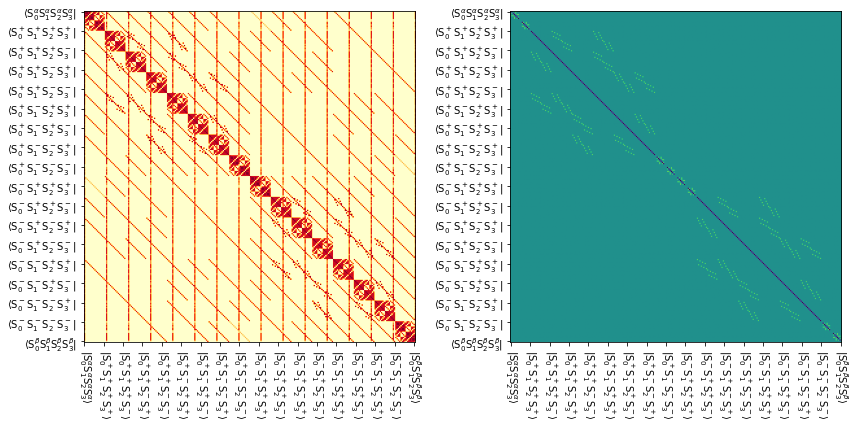

In [5]:
fig,ax=plt.subplots(1,2,figsize=[12,7])
L.plot(ax=ax[0],colorbar=False)
L.plot('Lrelax',mode='re',ax=ax[1],colorbar=False)
fig.tight_layout()

Now we observe the relaxation behavior of the spins, starting from saturation of all spins.

In [6]:
rho=sl.Rho('zero',['S0z','S1z','S2z','S3z'])

seq=L.Sequence(Dt=.1) #100 ms time step
_=rho.DetProp(seq,n=100)

<AxesSubplot:xlabel='t / s', ylabel='<Op>'>

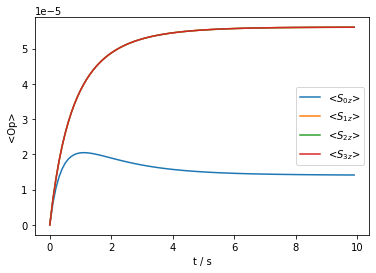

In [7]:
rho.plot(axis='s')

The $^13$C $T_1$ recovery results in a complex behavior due to polarization transfer to the three $^1$H. We can get a less complex behavior by saturating the $^1$H during the recovery.

In [12]:
rho=sl.Rho('zero',['S0z','S1z','S2z','S3z'])

seq=L.Sequence(Dt=0.1).add_channel('1H',v1=25000)
U=sl.LFrf(seq).U()

_=rho.DetProp(U,n=100)

LF calculation: |██████████████████████████████| 100% complete
Completed


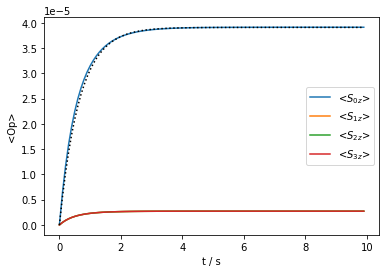

In [21]:
ax=rho.plot(axis='s')
ax.plot(rho.t_axis,3.91e-5*(1-np.exp(-rho.t_axis/.65)),color='black',linestyle=':')

By mostly saturating the $^1$H, we get a much more regular behavior for the $^{13}$C recovery. Note, however, that a relatively large field for saturation is required. The requirements for saturation can be reduced if we switch to a MAS experiment.

In [29]:
ex.vr=15000
L.clear_cache()

rho=sl.Rho('zero',['S0z','S1z','S2z','S3z'])

seq=L.Sequence().add_channel('1H',v1=25000)
U=sl.LFrf(seq).U()**1500

_=rho.DetProp(U,n=100)

LF calculation: |██████████████████████████████| 100% complete
Completed


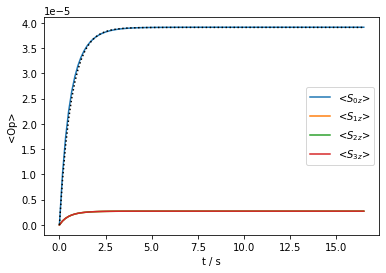

In [30]:
ax=rho.plot(axis='s')
ax.plot(rho.t_axis,3.91e-5*(1-np.exp(-rho.t_axis/.65)),color='black',linestyle=':')

In [28]:
L.taur*2500*100

16.666666666666668